# Classifying Facial Expressions

The objective of this project is to classify Facial Expressions. The data consists of 7 different expressions with 48x48 pixel grayscale images of faces. The training set consists of 28,709 examples and the test set consists of 3,589 examples. The data is folders of images from each class so I have to convert them into an appropriate dataframe with labels.

The data can be found on [kaggle](https://www.kaggle.com/msambare/fer2013)

### Importing Relevant Libraries

In [2]:
import os, pathlib
import numpy as np
import pandas as pd

import sklearn
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

In [40]:
#!pip install Image
from PIL import Image


#!pip install tensorflow
import tensorflow as tf
#from tensorflow.keras.preprocessing import image_dataset_from_directory

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

ImportError: SystemError: <built-in method __contains__ of dict object at 0x7fa0e0760cd0> returned a result with an error set

## Data

Import all the image data

In [22]:
import zipfile as zf

In [23]:
### Unzip the dataset folder


files = zf.ZipFile("image_data.zip", 'r')
files.extractall('directory to extract')
files.close()

In [24]:
### loading the data
dataset = 'directory to extract'

train_folder = os.path.join(dataset, "train")
test_folder = os.path.join(dataset,"test")
#validation_folder = os.path.join(dataset,"validation")

In [25]:
def count_data(rootdir):
    
    number_classes = {}
    for path in pathlib.Path(rootdir).iterdir():
        if path.is_dir():
           number_classes[str(path.name)] = str(len([name for name in os.listdir(path) if os.path.isfile(os.path.join(path, name))]))
        
    return number_classes

In [26]:
## Print dataset size for each image

print("Training size is: ")
print(count_data(train_folder))

#print()
#print("Validation size is: ")
#print(count_data(validation_folder))

print()
print("Test size is: ")
print(count_data(test_folder))

Training size is: 
{'sad': '4830', 'happy': '7215', 'fear': '4097', 'angry': '3995', 'surprise': '3171', 'disgust': '436', 'neutral': '4965'}

Test size is: 
{'sad': '1247', 'happy': '1774', 'fear': '1024', 'angry': '958', 'surprise': '831', 'disgust': '111', 'neutral': '1233'}


In [27]:
def get_dims(file):
    im = Image.open(file)
    arr = np.array(im)
    
    return arr.shape

Get dimensions of numpy array of an image. The images are all same size so we will just check size of one image.

In [28]:
## Print image size

get_dims(os.path.join(train_folder, 'angry/Training_3908.jpg'))

(48, 48)

## Data Cleaning & Preprocessing

In this section, I will convert folders of images into training and test dataset using numpy for further analysis of the data.

In [29]:
def get_array(file):
    '''
    return numpy array of an image
    '''
    im = Image.open(file)
    arr = np.array(im)
    
    return arr

In [30]:
# Get size for one sample after flattening and resizing 
len(list(get_array(os.path.join(train_folder, 'angry/Training_3908.jpg')).flatten()))

2304

In [31]:
## Resize images

image = Image.open(os.path.join(train_folder, 'angry/Training_3908.jpg'))
#new_image = image.resize((32,32))

arr1 = np.array(image)

In [32]:
arr1.shape

(48, 48)

In [33]:
## Create training and test dataset from our directory and split the data into x, y
def get_data(data_folder):
    '''
    Convert images and labels of a given folder into numpy arrays
    return x, y given a folder of images 
    '''
    lst_x = []
    lst_labels = []
    j = 0

    for expression_folder in sorted(os.listdir(data_folder)):
        if expression_folder != ".DS_Store":
            expression_items = os.listdir(os.path.join(data_folder, expression_folder))
            for i in range(len(expression_items)):
                arr = get_array(os.path.join(data_folder,expression_folder,expression_items[i])).flatten()
                arr = np.array(arr)
                lst_x.append(arr)
                lst_labels.append(j)
            j = j + 1
                
    return np.array(lst_x), np.array(lst_labels)

In [34]:
x_train, y_train = get_data(train_folder)
x_test, y_test = get_data(test_folder)

In [ ]:
## Print class names

print(count_data(train_folder).keys())

In order to reduce the complexity of the model, we will normalize the data so that the values are between 0 and 1 instead 0 and 255. This will alow for easier and faster computation

In [41]:
## Normalize the data

x_train_norm = x_train/255
x_test_norm = x_test/255

In [42]:
x_train_norm[0].shape

(2304,)

## Exploratory Data Analysis

Displays a random image from each class

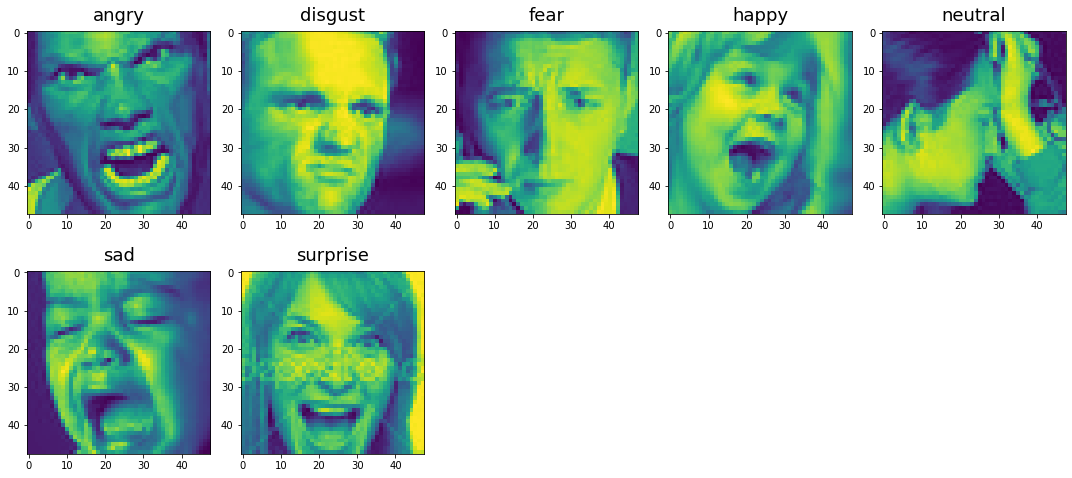

In [43]:
### Print an image from each class

images = []

for food_folder in sorted(os.listdir(train_folder)):
    if food_folder != ".DS_Store":
        food_items = os.listdir(os.path.join(train_folder, food_folder))
        food_selected = np.random.choice(food_items)
        images.append(os.path.join(train_folder,food_folder,food_selected))
                                     
fig=plt.figure(1, figsize=(15, 10))

for subplot,image_ in enumerate(images):
    category=image_.split('/')[-2]
    imgs = plt.imread(image_)
    a,b=imgs.shape
    fig=plt.subplot(3, 5, subplot+1)
    fig.set_title(category, pad = 10,size=18)
    plt.imshow(imgs)
    
plt.tight_layout()

Visualize the class imbalance. The classes are kind of balanced except for class 'Happy' and 'Disgust'. 'Happy' has the highest count of samples while 'Disgust' has signficantly lower sample size compared to other classes for training and test data.

In [48]:
import seaborn as sns

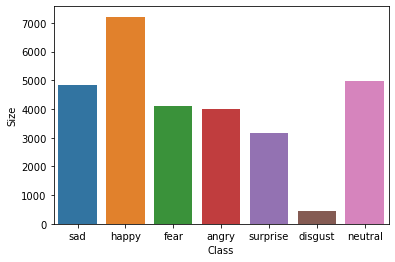

In [58]:
### Identifying training Class Imbalance

df_train = pd.DataFrame(count_data(train_folder).items(), columns=['Class', 'Size'])

ax = sns.barplot(x=df_test['Class'], y=df_test['Size'], data = df_train)


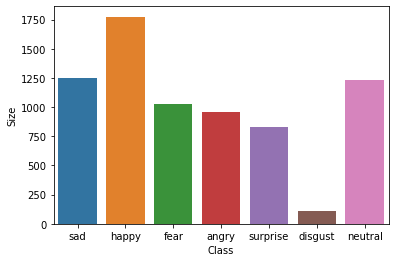

In [59]:
### Identifying test Class Imbalance

df_test = pd.DataFrame(count_data(test_folder).items(), columns=['Class', 'Size'])

ax = sns.barplot(x=df_test['Class'], y=df_test['Size'], data = df_test)

## Models

Since I am given data of images and labels, this is a classification problem so I will focus on classification models such as K nearest neighbors, Decision Tree, and Neural Network to compare accuracies. The total sample size is 32300 images however I have split the data into training and test data. Training set will have about 89% of the data and testing set will have 11%.

#### KNN Model

In [62]:
class KNN:
    """
    Class to store data for regression problems 
    """
    def __init__(self, x_train, y_train, K=5):
        """
        Creates a kNN instance

        :param data: Training data consisting of train_x and train_y elements
        :param K: The number of nearest points to consider in classification
        """
        
        # Import and build the BallTree on training features 
        from sklearn.neighbors import BallTree
        self.balltree = BallTree(x_train)
        
        # Cache training labels and parameter K 
        self.y_train = y_train
        self.K = K 
        
        
    def majority(self, neighbor_indices, neighbor_distances=None):
        """
        Given indices of nearest neighbors in training set, return the majority label. 
        Break ties by considering 1 fewer neighbor until a clear winner is found. 

        :param neighbor_indices: The indices of the K nearest neighbors in self.X_train 
        :param neighbor_distances: Corresponding distances from query point to K nearest neighbors. 
        """
        
        # your code here
        nearest_neighbors = self.y_train[[neighbor_indices]]
        
        from scipy import stats
        major_label = (max(set(nearest_neighbors.tolist()), key = nearest_neighbors.tolist().count))
        return major_label
        
    def classify(self, x):
        """
        Given a query point, return the predicted label 
        
        :param x: a query point stored as an ndarray  
        """
        # your code here
        dist, ind = self.balltree.query(x.reshape(1, -1), k=self.K)
        
        predicted_label = self.majority(ind.tolist()[0])
        return predicted_label
        
    def predict(self, X):
        """
        Given an ndarray of query points, return yhat, an ndarray of predictions 

        :param X: an (m x p) dimension ndarray of points to predict labels for 
        """
        # your code here
        yn = X.shape[0]
        yhat = np.array(yn*[0])
        
        for i in range(yn):
            yhat[i] = self.classify(X[i])
        
        yhat = yhat.reshape(-1, 1)
        return yhat

In [61]:
knn = sklearn.KNeighborsClassifier(n_neighbors = 5)
knn_model = knn.fit(x_train_norm, y_train)
test_yhat = knn.predict(x_test_norm)

AttributeError: module 'sklearn' has no attribute 'KNeighborsClassifier'

In [ ]:
sklearn.metrics.accuracy_score(y_test, test_yhat)

In [ ]:
acc = []
wacc = []

# your code here
for k in range(1,10):
    knn = KNN(x_train_norm, y_train, K = k)
    test_yhat = knn.predict(x_test_norm)
    acc.append(sklearn.metrics.accuracy_score(y_test, test_yhat))

#print(acc)
# you can use this code to create your plot    
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,7))
ax.plot(allks, acc, marker="o", color="steelblue", lw=3, label="unweighted")
ax.set_xlabel("number neighbors", fontsize=16)
ax.set_ylabel("accuracy", fontsize=16)
plt.xticks(range(1,31,2))
ax.grid(alpha=0.25)

In [74]:
knn = KNN(x_train_norm, y_train, K = 6)
test_yhat = knn.predict(x_test_norm)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error 

In [76]:
knn3 = KNN(x_train_norm, y_train, K = 3)
test_yhat3 = knn.predict(x_test_norm)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error 

In [77]:
print("Accuracy: " + str(sklearn.metrics.accuracy_score(y_test, test_yhat3)))
sklearn.metrics.confusion_matrix(data.val_y, val_yhat)

Accuracy: 0.32460295346893286


In [75]:
print("Accuracy: " + str(sklearn.metrics.accuracy_score(y_test, test_yhat)))

Accuracy: 0.32460295346893286


## Results and Analysis

The following are basic accuracies of each model. Based on the accuracy, we can see that the best model is __________.

Let's examine metrics such as confusion matrix, precision, recall, and ROC in order drill further down on the errors. 

## Discussion and Conclusion

The biggest challenge while working on this project was dealing with Big Data in terms of storage size. One of the datasets I was considering using had images of pixel size (226, 226, 3), where 3 represent RGB colors, but that was too computationally expensive so I had to find a small dataset. For this case, there would be 226*226*3 = 153,228 features. Fortunately, I found a dataset with gray scale images that are of pixel size (48, 48). For this case, there would only be 2304 features which is significantly less than the previous dataset. 

In order to further improve accuracy, I would have utilized bagging to make up for the class imbalance. For example, by randomly sampling from the orginal dataset with replacement to balance the classes. This would result in a higher dataset size and more accurate predictions of facial expressions. Furthermore, the model could have been tested and optimized for multiple hyperparameters such as K nearest neighbors, different tree depths for Decision Tree, or more layers in the neural network. 